# 자전거 대여량 예측 모델 

### 0. 라이브러리 불러오기

In [3]:
# 1. 데이터 처리와 분석
import pandas as pd
import numpy as np

# 2. 데이터 시각화
import matplotlib.pyplot as plt
import seaborn as sns

# 3. 데이터 전처리 및 머신러닝
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge 
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

plt.rcParams['font.family'] = 'gulim'
plt.rcParams['axes.unicode_minus'] = False
sns.set(font='gulim', rc={'axes.unicode_minus': False})

### 1. 데이터 불러오기

In [4]:
df = pd.read_csv('./data2/train.csv')
df.head(5)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


### 2. EDA분석

In [5]:
df.info()   #결측치 0
print("-"*50) 
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB
--------------------------------------------------


,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


info()함수의 결과를 통해 결측치가 없는 것을 확인, describe()함수를 통해 count의 최댓값의 이상치가 존재 가능성이 시사<br>
따라서 count의 이상치를 판단하기 위해 BOXPLOT을 사용해 이상치 확인<br> 
추가로 주요 학습 데이터로 사용예정인    humidity, windspeed,temp를 추가로 확인 예정

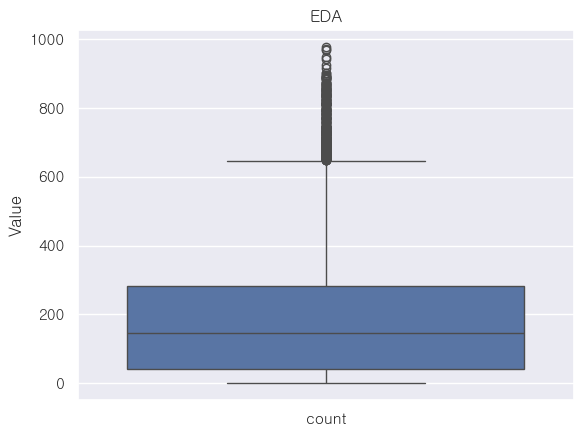

In [6]:
sns.boxplot(data=df[['count']])

plt.title('EDA')
plt.ylabel('Value')
plt.show()

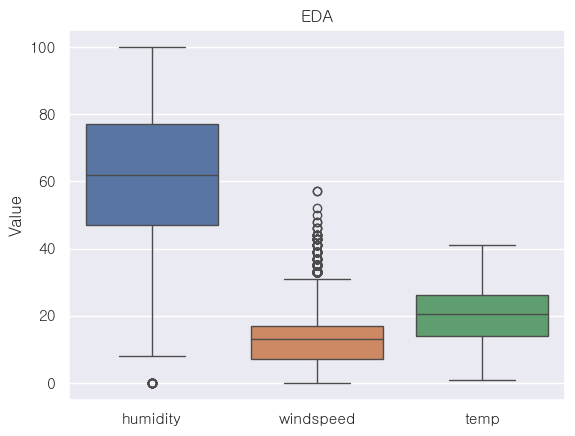

In [7]:
sns.boxplot(data=df[['humidity', 'windspeed', 'temp']])

plt.title('EDA')
plt.ylabel('Value')
plt.show()

count의 경우 학습데이터가 아닌 Target변수로서 이상치를 로그 변환을 통해 회귀모델의 예측 성능을 높일 예정<br>
windspeed의 경우 이상치가 많지만 실제 바람이 많이 부는 날일 경우의 수가 있으니 스케일링만 진행 예정 <br>
humidity의 경우 습도가 0%에 근접할 가능성이 매우 적으므로 시계열 데이터의 특성을 고려해 이전값의 값의 채우는 방식으로 이상치를 처리 예정

In [8]:
# 시간에 따른 자전거 대여량의 차이가 있을 거라 판단, DATE를 미리 분리
df['datetime'] = pd.to_datetime(df['datetime'])

df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['hour'] = df['datetime'].dt.hour
df['dayofweek'] = df['datetime'].dt.dayofweek
df.drop('datetime', axis=1, inplace=True)
df

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,hour,dayofweek
0,1,0,0,1,9.84,14.395,81,0.0000,3,13,16,2011,1,0,5
1,1,0,0,1,9.02,13.635,80,0.0000,8,32,40,2011,1,1,5
2,1,0,0,1,9.02,13.635,80,0.0000,5,27,32,2011,1,2,5
3,1,0,0,1,9.84,14.395,75,0.0000,3,10,13,2011,1,3,5
4,1,0,0,1,9.84,14.395,75,0.0000,0,1,1,2011,1,4,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,4,0,1,1,15.58,19.695,50,26.0027,7,329,336,2012,12,19,2
10882,4,0,1,1,14.76,17.425,57,15.0013,10,231,241,2012,12,20,2
10883,4,0,1,1,13.94,15.910,61,15.0013,4,164,168,2012,12,21,2
10884,4,0,1,1,13.94,17.425,61,6.0032,12,117,129,2012,12,22,2


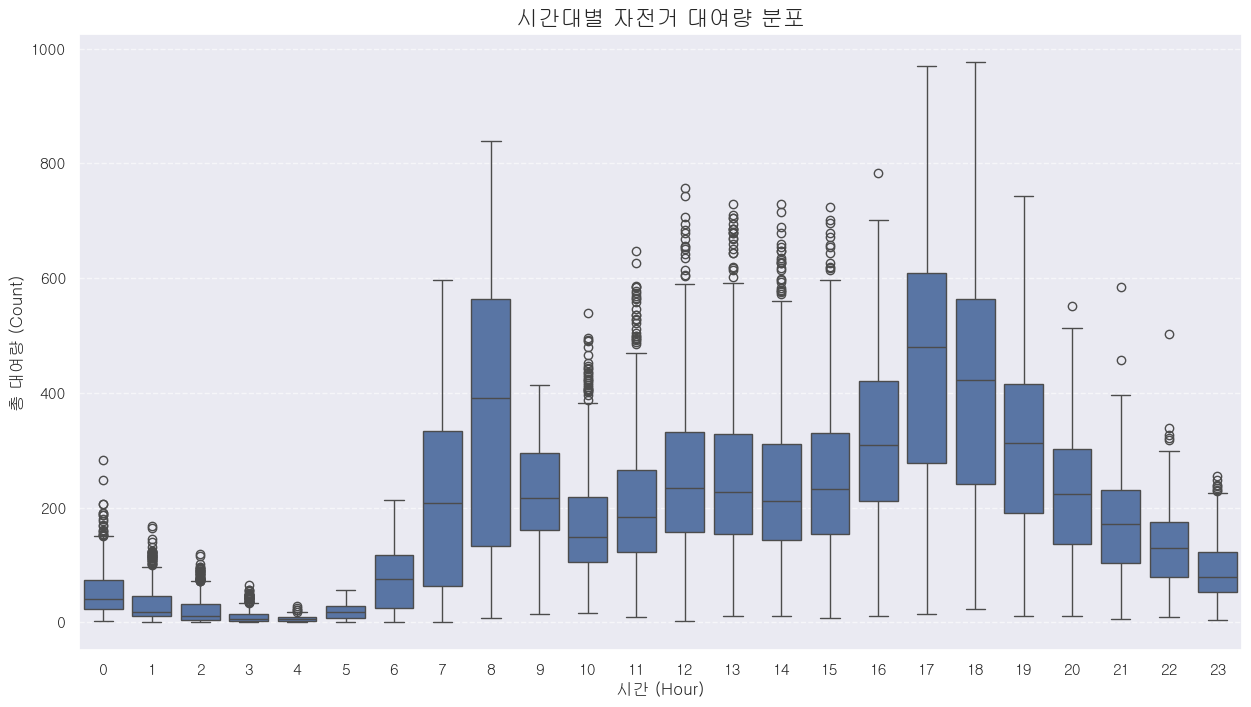

In [9]:
plt.figure(figsize=(15, 8))
sns.boxplot(x='hour', y='count', data=df)

plt.title('시간대별 자전거 대여량 분포', fontsize=16)
plt.xlabel('시간 (Hour)', fontsize=12)
plt.ylabel('총 대여량 (Count)', fontsize=12)
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.show()

특정시간대인 오전 8시와 오후5~6시에 대여량이 급증하는 뚜렷한 출퇴근 패턴을 확인,<br>

선형적 모델을 사용할 때 hour 피처는 원핫인코딩으로 전처리 필요하다고 판단.

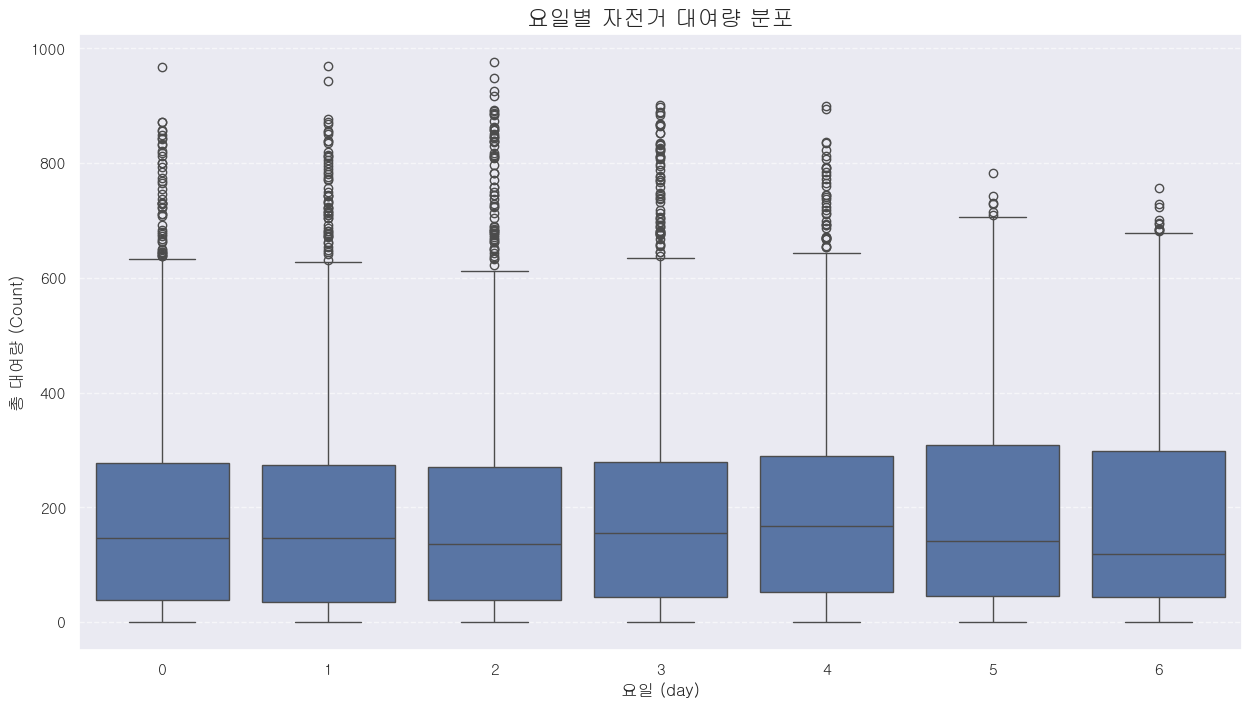

In [10]:
plt.figure(figsize=(15, 8))
sns.boxplot(x='dayofweek', y='count', data=df)

plt.title('요일별 자전거 대여량 분포', fontsize=16)
plt.xlabel('요일 (day)', fontsize=12)
plt.ylabel('총 대여량 (Count)', fontsize=12)
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.show()

주중과 주말의 이용패턴이 다르다는 것을 파악, hour과 결합하여 EDA를 진행

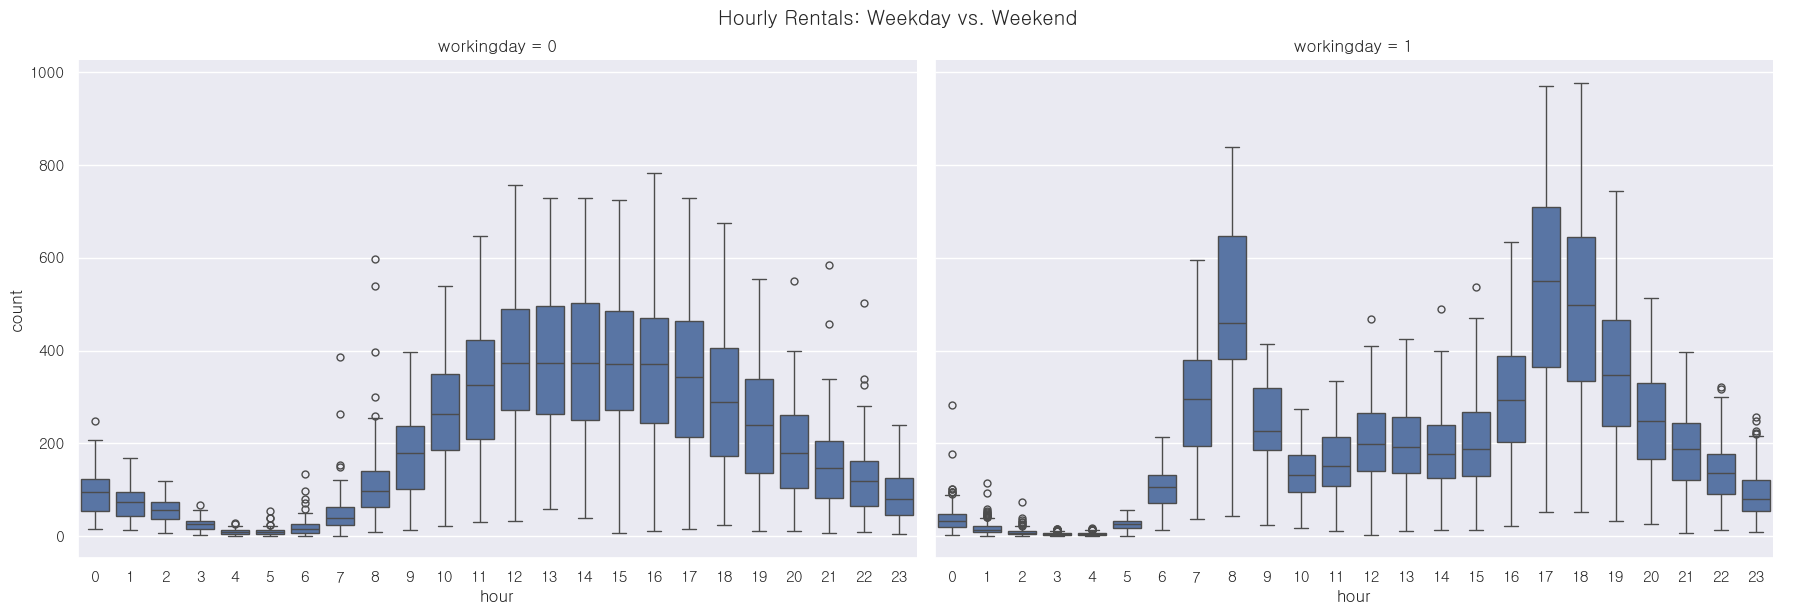

In [11]:
sns.catplot(x='hour', y='count', col='workingday', data=df, kind='box', 
            height=6, aspect=1.5)
plt.suptitle('Hourly Rentals: Weekday vs. Weekend', y=1.02) 
plt.show()

Workingday 1 : 주중에는 오전8시와 오후 5~6시에 대여량이 치솟는 뚜렷한 출퇴근 패턴을 보임<br>
Workingday 0 : 주말에는 낮시간대에 전반적으로 넓고 놉게 나타나는 것을 확인<br>
hour피처와 마찬가지로 workingday 피처도 원 핫 인코딩 처리 예정 

EDA마지막 단계로 숫자형 피처들간의 상관관계 확인

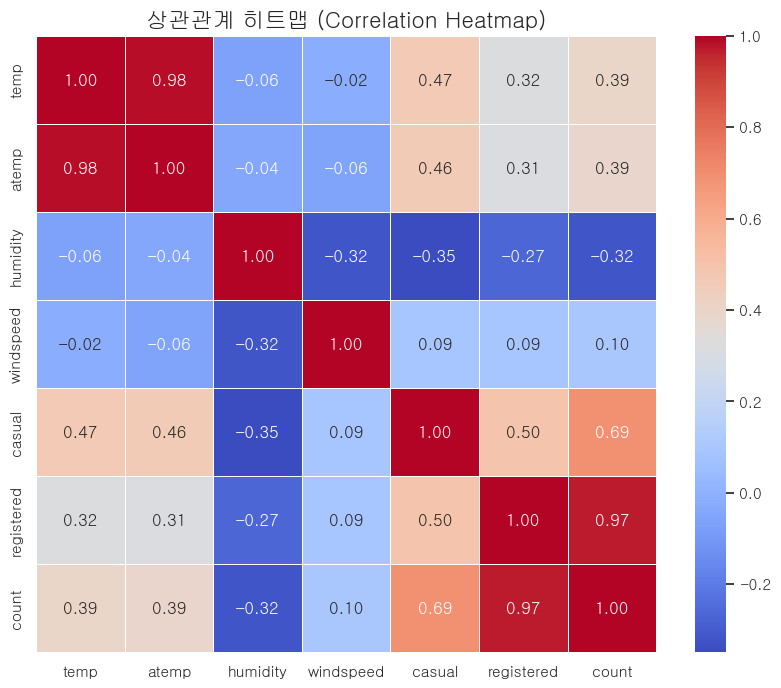

In [12]:
numerical_features = ['temp', 'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count']

# 상관관계 매트릭스 계산
corr_matrix = df[numerical_features].corr()

# 히트맵 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('상관관계 히트맵 (Correlation Heatmap)', fontsize=16)
plt.show()

temp와 atemp의 상관계수가 0.98로 두 변수가 서로 거의 같은 정보를 가지고 있다는 것을 판단,<br>
선형회귀모델에서 다중공선성 문제를 유발할 가능성이 있다고 판단 <Br>
atemp를 제거하는 전처리 과정을 거치기로 결정<br>

### EDA 결론 및 전처리 전략 

타겟 변수인 **count**는 분포가 한쪽으로 크게 치우쳐 있어 로그 변환을 통해 정규성을 확보. <br>
입력 변수 중 **humidity**에서 발견된 0 값은 오류로 판단, 시계열 특성을 살려 이전 시간의 값으로 대체.

자전거 대여량에 결정적인 영향을 미치는 **hour**와 **workingday**는 각 시간과 요일의 독립적인 특성을 모델이 학습하도록 원-핫 인코딩을 적용.

마지막으로, **temp**와 강한 상관관계를 보여 다중공선성 문제가 우려되는 **atemp**는 모델의 안정성을 위해 피처에서 제거하기로 결정했습니다.

### 3. 전처리

In [13]:
# humidity가 0인 값은 오류로 판단, 이전 시간의 값으로 대체
df['humidity'] = df['humidity'].replace(0, np.nan)
df['humidity'].fillna(method='ffill', inplace=True)

# temp와 상관관계가 0.98로 다중공선성문제가 우려되는 atemp 열 제거
df.drop('atemp', axis=1, inplace=True)

# count열은 target으로 로그 변환을 하여 정규성확보
y_target = np.log1p(df['count'])

# 피처(X)에서 타겟 및 데이터 누수 변수(casual, registered) 제외
X_features = df.drop(['casual', 'registered', 'count'], axis=1)

# 범주형 특성을 갖는 변수들을 원-핫 인코딩
categorical_features = ['year', 'month', 'hour', 'dayofweek', 'season', 'weather', 'holiday', 'workingday']
X_features_ohe = pd.get_dummies(X_features, columns=categorical_features)


# --- 최종 준비 완료 ---
print("전처리 완료! 모델 학습을 위한 데이터가 준비되었습니다.")
print("피처 데이터 형태:", X_features_ohe.shape)
print("타겟 데이터 형태:", y_target.shape)

전처리 완료! 모델 학습을 위한 데이터가 준비되었습니다.
피처 데이터 형태: (10886, 60)
타겟 데이터 형태: (10886,)


C:\Users\Admin\AppData\Local\Temp\ipykernel_20936\1239978422.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['humidity'].fillna(method='ffill', inplace=True)
C:\Users\Admin\AppData\Local\Temp\ipykernel_20936\1239978422.py:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['humidity'].fillna(method='ffill', inplace=True)


In [14]:
# 피처 스케일링
X_train, X_test, y_train, y_test = train_test_split(X_features_ohe, y_target, test_size=0.3, random_state=42)

scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

### 4. 모델학습시키기

### LinearRegression모델

In [15]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

# 평가를 위해 원래 스케일로 되돌리기
y_test_exp = np.expm1(y_test)
predictions_exp = np.expm1(y_pred)

# 평가
mse = mean_squared_error(y_test_exp, predictions_exp)
rmse = np.sqrt(mse)

# 결정계수 
r2 = r2_score(y_test_exp, predictions_exp)

print("--- 최종 모델 평가 결과 ---")
print(f"RMSE: {rmse:.3f}")
print(f"R² Score: {r2:.3f}")

--- 최종 모델 평가 결과 ---
RMSE: 97.174
R² Score: 0.710


본 선형 회귀 모델은 결정계수(R²) 0.71을 기록하여 준수한 성능을 보이지만, <BR>
평균 제곱근 오차(RMSE)는 약 97.1로 나타나 개별 예측정밀도에는 한계가 있음을 확인<BR>
따라서 CrossValidation을 진행하도록 하겠습니다

In [16]:
# 1. 스케일러와 모델을 파이프라인으로 묶기
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('linear_reg', LinearRegression())
])

# 2. 파이프라인을 모델처럼 사용하여 교차 검증 수행
# 데이터는 스케일링 전의 원-핫 인코딩된 데이터를 사용합니다.
neg_mse_scores = cross_val_score(pipeline, X_features_ohe, y_target, 
                                 scoring='neg_mean_squared_error', cv=5)

# 3. 결과 확인 및 변환
rmse_scores = np.sqrt(-neg_mse_scores)
avg_rmse = np.mean(rmse_scores)

print(f"개별 Fold의 RMSE 점수: {np.round(rmse_scores, 3)}")
print(f"평균 RMSE: {avg_rmse:.3f}")

개별 Fold의 RMSE 점수: [6.6700000e-01 5.9800000e-01 1.1748309e+10 5.8500000e-01 5.6700000e-01]
평균 RMSE: 2349661805.474


한 개의 FOLD에서 RMSE가 비정상적으로 크게 나왔고 선형회귀모델의 단점이라고 판단 <br>
안정성을 높이기 위해 규제가 있는 Ridge 모델을 도입

In [17]:
# 1. 스케일러와 안정적인 Ridge 모델을 파이프라인으로 묶기
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge_reg', Ridge()) 
])

# 2. RMSE 점수 계산 
neg_mse_scores = cross_val_score(pipeline, X_features_ohe, y_target, 
                                 scoring='neg_mean_squared_error', cv=5)
rmse_scores = np.sqrt(-neg_mse_scores)
avg_rmse = np.mean(rmse_scores)

# 3. R² 점수 계산
r2_scores = cross_val_score(pipeline, X_features_ohe, y_target, 
                            scoring='r2', cv=5)
avg_r2 = np.mean(r2_scores)

# --- 최종 교차 검증 결과 ---
print(f"개별 Fold의 RMSE 점수: {np.round(rmse_scores, 3)}")
print(f"평균 RMSE: {avg_rmse:.3f}\n") 

print(f"개별 Fold의 R² 점수: {np.round(r2_scores, 3)}")
print(f"평균 R²: {avg_r2:.3f}")

개별 Fold의 RMSE 점수: [0.668 0.599 0.642 0.584 0.566]
평균 RMSE: 0.612

개별 Fold의 R² 점수: [0.76  0.792 0.785 0.825 0.826]
평균 R²: 0.798


규제가 포함된 Ridge회귀모델로 교차검증을 수행한 결과, 평균 결정계수(R²)는 약 0.80을 기록.<br>
이는 해당 모델이 약 80%의 뛰어난 예측력을 가졌고, 안정적인 성능을 기록.

Ridge 회귀모델 <br>
피처의 크기(Scale)에 민감한 선형 모델의 특성을 고려하여, <br>
StandardScaler로 정규화된 데이터를 학습에 사용

### RandomForestRegressor모델

In [18]:
lr_r = RandomForestRegressor()
lr_r.fit(X_train, y_train)
y_pred1 = lr_r.predict(X_test)

# 평가를 위해 원래 스케일로 되돌리기
y_test_exp = np.expm1(y_test)
predictions_exp1 = np.expm1(y_pred1)

# 평가
mse = mean_squared_error(y_test_exp, predictions_exp1)
rmse = np.sqrt(mse)

# 결정계수 
r2 = r2_score(y_test_exp, predictions_exp1)

print("--- 최종 모델 평가 결과 ---")
print(f"RMSE: {rmse:.3f}")
print(f"R² Score: {r2:.3f}")

--- 최종 모델 평가 결과 ---
RMSE: 46.043
R² Score: 0.935


RandomForestRegressor 모델이 R² Score: 0.935 매우 뛰어난 성능을 보여줌,<BR>
RMSE 값이 약 46.1로 Ridge모델의 실제 오차보다 크게 줄여 예측의 정밀도가 높음.

In [19]:
# 교차검증 
rf_reg = RandomForestRegressor(random_state=42, n_jobs=-1)

# RMSE 점수 계산

neg_mse_scores = cross_val_score(rf_reg, X_features_ohe, y_target,
                                 scoring='neg_mean_squared_error', cv=5)
rmse_scores = np.sqrt(-neg_mse_scores)
avg_rmse = np.mean(rmse_scores)

# R² 점수 계산
r2_scores = cross_val_score(rf_reg, X_features_ohe, y_target,
                            scoring='r2', cv=5)
avg_r2 = np.mean(r2_scores)

# --- RandomForest 교차 검증 결과 ---
print(f"개별 Fold의 RMSE 점수: {np.round(rmse_scores, 3)}")
print(f"평균 RMSE: {avg_rmse:.3f}\n")

print(f"개별 Fold의 R² 점수: {np.round(r2_scores, 3)}")
print(f"평균 R²: {avg_r2:.3f}")

개별 Fold의 RMSE 점수: [0.702 0.375 0.446 0.349 0.412]
평균 RMSE: 0.457

개별 Fold의 R² 점수: [0.736 0.918 0.896 0.937 0.908]
평균 R²: 0.879


RandomForestRegressor 모델을 5-fold 교차검증을 실시한 결과,<BR>
평균계수(R²)는 약 0.88로 매우 높은 성능을 보임,<BR>
평균 RMSE는 약 0.46으로 선형모델 대비 예측 오차를 크게 줄인 결과를 보임.<BR>

RandomForest 모델 <br>
피처 스케일링에 영향을 받지 않는 트리 기반 모델의 특성에 따라, <br>
원-핫 인코딩만 완료된 비정규화 데이터를 학습에 사용했습니다<br>

### XGBoost 모델

In [20]:
# XGBoost 모델을 위해 분할된 데이터의 복사본 생성
X_train_xgb = X_train.copy()
X_test_xgb = X_test.copy()

# XGBoost 호환성을 위해 복사본의 열 이름에서 특수 문자를 제거
X_train_xgb.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in X_train_xgb.columns]
X_test_xgb.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in X_test_xgb.columns]

# XGBoost 모델 생성 및 학습
xgb_reg = xgb.XGBRegressor(random_state=42, n_jobs=-1)
xgb_reg.fit(X_train_xgb, y_train)

# 테스트 데이터로 예측 수행
y_pred_xgb = xgb_reg.predict(X_test_xgb)

# 평가를 위해 원래 스케일로 되돌리기
y_test_exp = np.expm1(y_test)
predictions_exp_xgb = np.expm1(y_pred_xgb)

# 평가
mse = mean_squared_error(y_test_exp, predictions_exp_xgb)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_exp, predictions_exp_xgb)

print("--- XGBoost 모델 평가 결과 ---")
print(f"RMSE: {rmse:.3f}")
print(f"R² Score: {r2:.3f}")

--- XGBoost 모델 평가 결과 ---
RMSE: 46.514
R² Score: 0.934


In [23]:
xgb_reg = xgb.XGBRegressor(random_state=42, n_jobs=-1)

# RMSE 점수 계산
neg_mse_scores_xgb = cross_val_score(xgb_reg, X_features_ohe, y_target,
                                     scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
rmse_scores_xgb = np.sqrt(-neg_mse_scores_xgb)
avg_rmse_xgb = np.mean(rmse_scores_xgb)

# R² 점수 계산
r2_scores_xgb = cross_val_score(xgb_reg, X_features_ohe, y_target,
                                scoring='r2', cv=5, n_jobs=-1)
avg_r2_xgb = np.mean(r2_scores_xgb)

# --- XGBoost 교차 검증 결과 ---
print(f"개별 Fold의 RMSE 점수: {np.round(rmse_scores_xgb, 3)}")
print(f"평균 RMSE: {avg_rmse_xgb:.3f}\n")

print(f"개별 Fold의 R² 점수: {np.round(r2_scores_xgb, 3)}")
print(f"평균 R²: {avg_r2_xgb:.3f}")

개별 Fold의 RMSE 점수: [0.624 0.336 0.383 0.334 0.356]
평균 RMSE: 0.407

개별 Fold의 R² 점수: [0.791 0.934 0.923 0.943 0.931]
평균 R²: 0.905


XGBoost 모델을 5-fold 교차검증을 실시한 결과,<BR>
평균계수(R²)는 약 0.90로 매우 높은 성능을 보임,<BR>
평균 RMSE는 약 0.40으로 랜덤포레스트모델 대비 예측 오차가 줄어든 결과를 보임.<BR>

XGBoost 모델<br>
RandomForest와 동일하게 스케일링은 적용하지 않았으며,<br>
라이브러리 호환성 확보를 위해 열 이름의 특수 문자를 제거한 데이터를 학습에 사용했습니다<br>

### 5. 하이퍼파라미터튜닝

In [29]:
# 1. 각 모델의 파이프라인 및 하이퍼파라미터 탐색 범위 정의

# 릿지(Ridge) 모델
pipe_ridge = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', Ridge())
])
param_ridge = {
    'ridge__alpha': uniform(0.1, 10)
}

# 랜덤 포레스트(RandomForest) 모델
pipe_rf = Pipeline([
    ('rf', RandomForestRegressor(random_state=42))
])
param_rf = {
    'rf__n_estimators': randint(100, 500),
    'rf__max_depth': randint(10, 30),
    'rf__min_samples_leaf': randint(1, 10),
    'rf__min_samples_split': randint(2, 20)
}

# XGBoost 모델
pipe_xgb = Pipeline([
    ('xgb', xgb.XGBRegressor(random_state=42))
])
param_xgb = {
    'xgb__n_estimators': randint(100, 1000),
    'xgb__max_depth': randint(3, 10),
    'xgb__learning_rate': uniform(0.01, 0.3),
    'xgb__subsample': uniform(0.6, 0.4),
    'xgb__colsample_bytree': uniform(0.6, 0.4)
}


# 2. RandomizedSearchCV 객체 딕셔너리 생성

random_searches = {
    "Ridge": RandomizedSearchCV(pipe_ridge, param_distributions=param_ridge, n_iter=50, cv=5, scoring='r2', random_state=42, n_jobs=-1),
    "RandomForest": RandomizedSearchCV(pipe_rf, param_distributions=param_rf, n_iter=50, cv=5, scoring='r2', random_state=42, n_jobs=-1),
    "XGBoost": RandomizedSearchCV(pipe_xgb, param_distributions=param_xgb, n_iter=50, cv=5, scoring='r2', random_state=42, n_jobs=-1)
}


# 3. 모든 모델 학습 및 결과 저장
results = {}
for name, search in random_searches.items():
    print(f"--- {name} 모델 하이퍼파라미터 튜닝 시작 ---")
    search.fit(X_features_ohe, y_target)
    results[name] = {
        "best_score": search.best_score_,
        "best_params": search.best_params_
    }
    print(f"--- {name} 튜닝 완료 ---")


# 4. 최종 결과 요약 출력
print("\n\n--- 최종 튜닝 결과 요약 ---")
for name, result in results.items():
    print(f"\n모델: {name}")
    print(f"교차 검증 최고 R² 점수: {result['best_score']:.4f}")
    print(f"최적 파라미터: {result['best_params']}")

--- Ridge 모델 하이퍼파라미터 튜닝 시작 ---
--- Ridge 튜닝 완료 ---
--- RandomForest 모델 하이퍼파라미터 튜닝 시작 ---
--- RandomForest 튜닝 완료 ---
--- XGBoost 모델 하이퍼파라미터 튜닝 시작 ---
--- XGBoost 튜닝 완료 ---


--- 최종 튜닝 결과 요약 ---

모델: Ridge
교차 검증 최고 R² 점수: 0.7976
최적 파라미터: {'ridge__alpha': np.float64(9.799098521619943)}

모델: RandomForest
교차 검증 최고 R² 점수: 0.8772
최적 파라미터: {'rf__max_depth': 26, 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 3, 'rf__n_estimators': 319}

모델: XGBoost
교차 검증 최고 R² 점수: 0.9186
최적 파라미터: {'xgb__colsample_bytree': np.float64(0.632341330533086), 'xgb__learning_rate': np.float64(0.12089633681842132), 'xgb__max_depth': 3, 'xgb__n_estimators': 866, 'xgb__subsample': np.float64(0.9212559025519583)}


하이퍼파라미터 튜닝 결과 <BR>
Ridge 모델의 최고 R² 점수는 약 79.8%로 높은 성능을 기록 <BR>
RandomForest 모델의 최고 R² 점수는 약 87.7%로 매우 높은 성능을 기록함<br>
XGBoost 모델의 최고 R² 점수는 약 0.92로 가장 높은 성능을 기록함

# 결론

# 최종모델 선정 : XGBoost

### 추가 - 최종 모델의 피처 중요도  확인 

C:\Users\Admin\AppData\Local\Temp\ipykernel_20936\1327378460.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax_xgb = sns.barplot(x=top_features_xgb.values, y=top_features_xgb.index, palette='rocket', edgecolor='black')


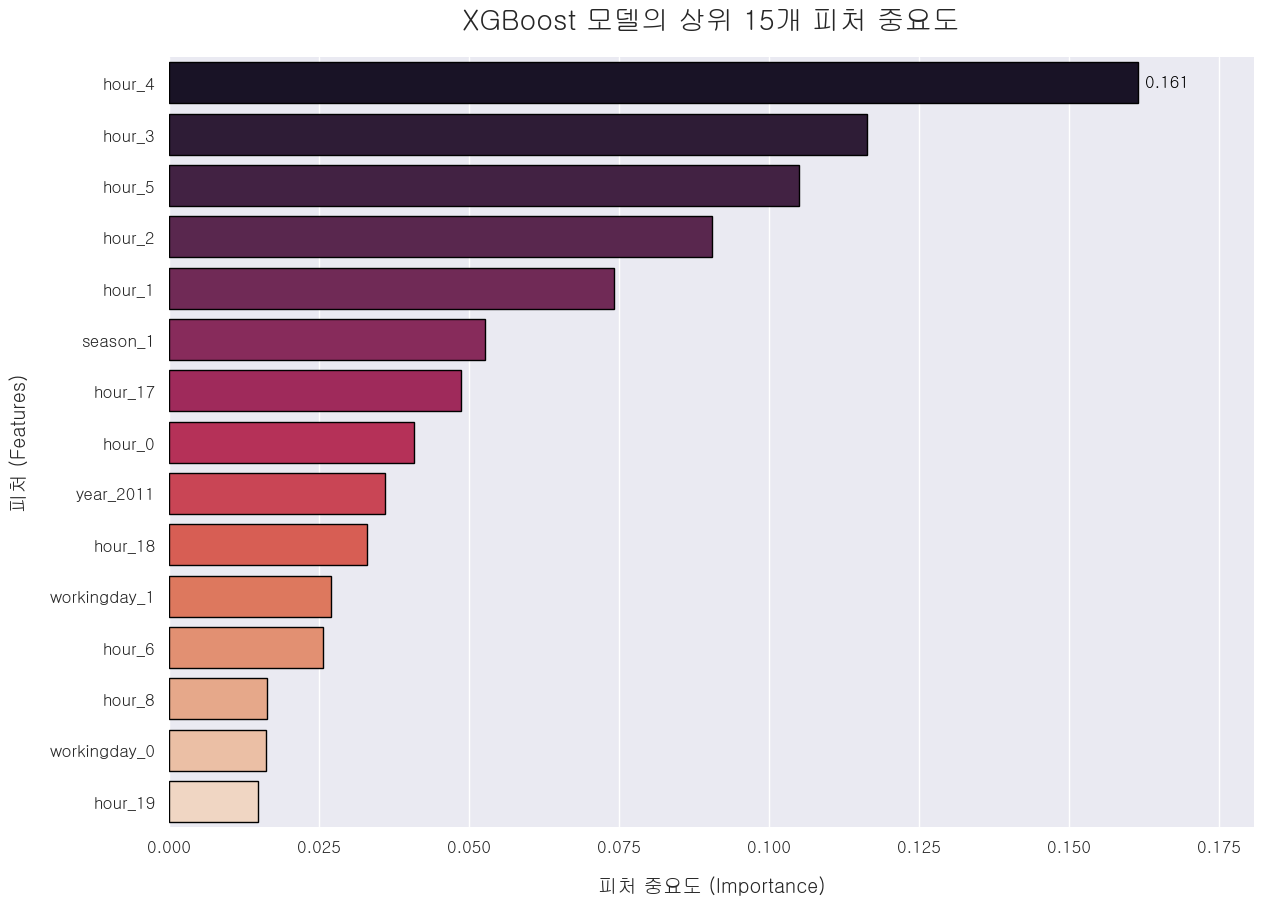

In [30]:
# 최적의 XGBoost 모델
best_xgb_model = random_searches['XGBoost'].best_estimator_

# XGBoost 모델에서 피처 중요도 추출
feature_importances_xgb = best_xgb_model.named_steps['xgb'].feature_importances_
feature_series_xgb = pd.Series(feature_importances_xgb, index=X_features_ohe.columns)
top_features_xgb = feature_series_xgb.sort_values(ascending=False).head(15)

# 시각화 코드 
plt.figure(figsize=(14, 10))
ax_xgb = sns.barplot(x=top_features_xgb.values, y=top_features_xgb.index, palette='rocket', edgecolor='black')

ax_xgb.bar_label(ax_xgb.containers[0], fmt='%.3f', padding=5, fontsize=12, color='black', weight='bold')

plt.title('XGBoost 모델의 상위 15개 피처 중요도', fontsize=20, pad=20, weight='bold')
plt.xlabel('피처 중요도 (Importance)', fontsize=14, labelpad=15)
plt.ylabel('피처 (Features)', fontsize=14, labelpad=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(0, top_features_xgb.max() * 1.12)
sns.despine(left=True, bottom=True)

plt.show()

### 추가 
피처 중요도 결과는 EDA 과정에서 세웠던 가설인 '시간대별 주기성', '주중/주말 패턴'등이 <BR>
실제로 자전거 대여량 예측 핵심 요인이였단 것을 증명<BR>
모델의 높은 성능의 이유를 주요 패턴을 성공적으로 학습시켰다는 것을 시사함